imports

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive',  force_remount=True)
data_path = '/content/drive/My Drive/Onto_UML_Data/Relation_Images2/'


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import time


from sklearn.model_selection import KFold, StratifiedKFold
from os import listdir
from os.path import isfile, join

Mounted at /content/drive


ml imports

In [21]:
import keras

from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.models import Model
from keras.models import Sequential

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

image size

In [22]:
image_size = (100, 100)
image_height, image_width = image_size

prep image by resizing to 100x100, and doing data augmentation

In [23]:
def resize_and_augment_img(image_path):
    # Read image
    image = cv2.imread(image_path)

    # Resize image to 100x100
    resized_image = cv2.resize(image, image_size)

    # List to hold all augmented images
    augmented_images = []

    # Rotations: 0, 90, 180, 270 degrees
    for k in range(4):
        # Rotate the image
        rotated_image = np.rot90(resized_image, k)

        augmented_images.append(rotated_image)

        # Mirror the image horizontally
        mirrored_image = np.fliplr(rotated_image)
        augmented_images.append(mirrored_image)

    return augmented_images

# Example usage:
# augmented_images = resize_and_augment_img("path_to_your_image.jpg")
# for idx, img in enumerate(augmented_images):
#     cv2.imwrite(f"augmented_image_{idx}.jpg", img)

Go over image directories and create dataset arrays

In [24]:
def preprocess_and_create_xy_arrays(input_dirs):

    df = pd.DataFrame()  # Initialize an empty DataFrame

    images = []  # List to store image data
    labels = []  # List to store class labels

    cntr = 0;
    for class_label, input_dir in enumerate(input_dirs):
        for filename in os.listdir(input_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                input_path = os.path.join(input_dir, filename)
                augmented_images = resize_and_augment_img(input_path)
                for ag_img in augmented_images:
                  images.append(ag_img)
                  labels.append(class_label)

    images_array = np.array(images)
    labels_array = np.array(labels)
    return images_array, labels_array


Use previous methods to load in training images

In [25]:
input_dirs = [f"{data_path}/GEN", f"{data_path}/REL", f"{data_path}/END"]
X, y = preprocess_and_create_xy_arrays(input_dirs)

Flatten image arrays and splint into training, validataion and test datasets

In [26]:
# Flatten image arrays
X = X.reshape(-1, image_height, image_width, 3)  # Assuming grayscale images, use 3 instead of 1 for RGB images

# Split the Data into Training and Validation Sets

# Split the Data into Training and Test Sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the Training Set into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
# Note: test_size=0.25 of 80% (remaining data) results in 20% validation data

Load InceptionV3 model and add necessary layers

In [27]:
# Load Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Freeze Layers
for layer in base_model.layers[:175]:
    layer.trainable = False
for layer in base_model.layers[175:]:
    layer.trainable = True

# Add Additional Layers
x = base_model.output
# Add pooling layer
x = GlobalAveragePooling2D()(x)
# Add final layer for classification
predictions = Dense(3, activation='softmax')(x)  # Add an output layer

# Initialise the Model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train Model

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# learning rate reduction to avoid overfitting
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-4
    )


print("training model")
# Train the Model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),  callbacks=[early_stopping, reduce_learning_rate])

# Evaluate the Model (optional)
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", accuracy)


training model
Epoch 1/10
29/29 [==============================] - 55s 1s/step - loss: 0.8556 - accuracy: 0.6992 - val_loss: 65.7644 - val_accuracy: 0.3766 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - 40s 1s/step - loss: 0.5388 - accuracy: 0.8252 - val_loss: 275.1922 - val_accuracy: 0.3550 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - 40s 1s/step - loss: 0.3895 - accuracy: 0.8903 - val_loss: 1.2672 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 4/10
29/29 [==============================] - 39s 1s/step - loss: 0.2925 - accuracy: 0.9088 - val_loss: 1.5220 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 5/10
29/29 [==============================] - 42s 1s/step - loss: 0.2429 - accuracy: 0.9099 - val_loss: 0.8762 - val_accuracy: 0.7316 - lr: 0.0010
Epoch 6/10
29/29 [==============================] - 40s 1s/step - loss: 0.1849 - accuracy: 0.9316 - val_loss: 1.2426 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 7/10
29/29 [==============================] - 39s 1s/step 

Run on test set to evaluate performance

9/9 [==============================] - 5s 525ms/step - loss: 0.5976 - accuracy: 0.8854
Test Loss: 0.5976424813270569
Test Accuracy: 0.8854166865348816
9/9 [==============================] - 8s 658ms/step


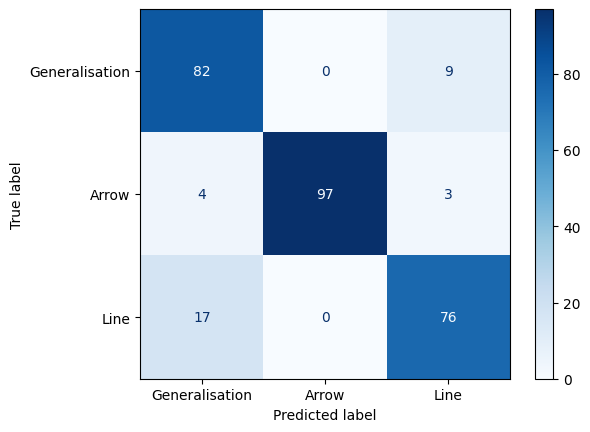

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Print confusion matrix
y_pred_prob = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
labels = ["Generalisation", "Arrow", "Line"]  # Update with your actual class labels if needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

import matplotlib.pyplot as plt
plt.show()


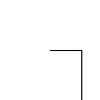

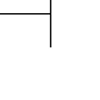

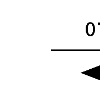

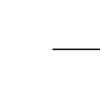

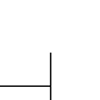

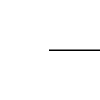

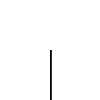

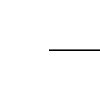

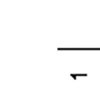

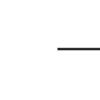

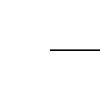

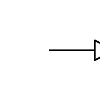

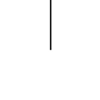

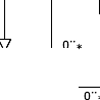

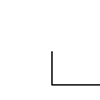

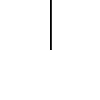

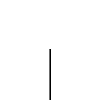

In [31]:
def display_false_positives(X_test, y_test, y_pred, target_label=1, true_label=0):
    """
    Display images where y_pred is target_label but y_test is true_label.

    Parameters:
    - X_test: Array of test images.
    - y_test: Array of true labels.
    - y_pred: Array of predicted labels.
    - target_label: The predicted label of interest (default is 1).
    - true_label: The true label of interest (default is 0).
    - num_images: Number of images to display (default is 10).
    """
    # Find indices where y_pred is target_label but y_test is true_label
    false_positive_indices = np.where((y_pred == target_label) & (y_test == true_label))[0]
    for fp in false_positive_indices:
      image = X_test[fp].reshape((image_height,image_width, 3))

      # Display the image
      cv2_imshow(image)
display_false_positives(X_test, y_test, y_pred, 0, 2)




Save model

In [32]:
model.save(f'{data_path}/Relationship_classifier')

# Example: Using the model to classify an image

Load model

In [51]:
import tensorflow as tf
# Load model
model_path = f'{data_path}/Relationship_classifier'
model = tf.keras.models.load_model(model_path)


Load image and pre-process

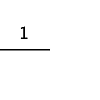

1/1 [==============================] - 0s 117ms/step
[[0.00333772 0.00171825 0.99494404]]
[2]


In [61]:
def classify_relation_sign(image, model, input_size = (100,100)):
    # Resize to the image size the model takes

    image_resized = cv2.resize(image, input_size)
    cv2_imshow(image_resized)
    # Convert to rgb
    #rgb_image = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)


    # Add batch dimension
    image_batch = np.expand_dims(image_resized, axis=0)


    # Predict the class probabilities
    predictions = model.predict(image_batch)
    print(predictions)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class



image_path = "virtual-currency-and-exchange-power17.png"
image = cv2.imread(image_path)

cls = classify_relation_sign(image, model, (image_height, image_width))
print(cls)